## model try


### Load libraries

In [1]:
from cv2 import cv2
import os
import json
import time

import pathlib
from torch.utils.data import DataLoader
import sys
sys.path.append('../')
from tqdm import tqdm
import numpy as np

from PIL import Image

#for model
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator, RPNHead, RegionProposalNetwork
from torchvision.models.detection.faster_rcnn import *
import torch

#DERT model
from transformers import DetrForObjectDetection


<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
print(os.getcwd())  

c:\Users\spiro\OneDrive\Υπολογιστής\Thesis\Project\master_thesis_dtu\notebooks


### Here we will preprocessing the data to turn them into a COCO format style necessary for the DERT model to run 

#### This is the image format needed

```python
{
    'id': 1,
    'file_name': 'path/to/your/image1.png',
    'height': 480,
    'width': 640
}
```

#### This is the annotation format needed 

```python
"annotations": [
        {
            "id": 1,
            "image_id": 1,
            "category_id": 1,
            "bbox": [5, 920, 33, 62],
            "area": 2046,
            "segmentation": [],
            "iscrowd": 0
        },]
```

#### And this is the final dataset format

```python
{
    'info': {
        'description': 'My dataset in COCO format',
        'url': 'https://example.com/dataset',
        'version': '1.0',
        'year': 2023,
        'contributor': 'John Doe',
        'date_created': '2023-03-02'
    },
    'licenses': [
        {
            'id': 1,
            'name': 'CC-BY-4.0',
            'url': 'https://creativecommons.org/licenses/by/4.0/'
        }
    ],
    "categories": [
        {
            "id": 1,
            "name": "text"
        },
        {
            "id": 2,
            "name": "fracture"
        },
        {
            "id": 3,
            "name": "axis"
        }
    ],
    "images": [
        {
            "id": 1,
            "file_name": "path/to/your/image1.png",
            "width": 499,
            "height": 1034
        }
    ],
    "annotations": [
        {
            "id": 1,
            "image_id": 1,
            "category_id": 1,
            "bbox": [5, 920, 33, 62],
            "area": 2046,
            "segmentation": [],
            "iscrowd": 0
        },
        {
            "id": 2,
            "image_id": 1,
            "category_id": 2,
            "bbox": [152, 456, 143, 67],
            "area": 9571,
            "segmentation": [],
            "iscrowd": 0
        }
    ]
}
```

In [3]:
#Set path to root dir (wrist folder)
root_dir = pathlib.Path('../literature/Other/supervisely')

# Path to annotation dir
ann_dir = pathlib.Path(root_dir, 'wrist/ann')

# Path to image dir
img_dir = pathlib.Path(root_dir, 'wrist/img')

# Lists
list_files = lambda start_dir: [str(item) for item in start_dir.iterdir()]
ann_list = list_files(ann_dir)
img_list = list_files(img_dir)
print('Number of annotations: {}'.format(len(ann_list)))

Number of annotations: 20327


#### Fix one and then make a function for the others


In [4]:
idx = 1
img_path = os.path.join(img_list[idx])
ann_path = os.path.join(ann_list[idx])

In [5]:
#fix info
info = {
        'description': 'My dataset in COCO format',
        'url': 'nan',
        'version': '1.0',
        'year': 2023,
        'contributor': 'Spyros Vlachospyros',
        'date_created': '2023-03-02'
}
info

{'description': 'My dataset in COCO format',
 'url': 'nan',
 'version': '1.0',
 'year': 2023,
 'contributor': 'Spyros Vlachospyros',
 'date_created': '2023-03-02'}

In [6]:
licenses =  [
        {
            'id': 1,
            'name': 'CC-BY-4.0',
            'url': 'https://creativecommons.org/licenses/by/4.0/'
        }
    ]
licenses

[{'id': 1,
  'name': 'CC-BY-4.0',
  'url': 'https://creativecommons.org/licenses/by/4.0/'}]

In [7]:
#fix the categories 

categories = [
        {
            "id": 2,
            "name": "text"
        },
        {
            "id": 1,
            "name": "fracture"
        }]

categories

[{'id': 2, 'name': 'text'}, {'id': 1, 'name': 'fracture'}]

In [8]:
#fix the images format

image_id = 1
file_name = img_path

image = Image.open(img_path)

# Get the width and height of the image
width, height = image.size

images =  [
        {
            "id": image_id,
            "file_name": file_name,
            "width": width,
            "height": height
        }
    ]
images

[{'id': 1,
  'file_name': '..\\literature\\Other\\supervisely\\wrist\\img\\0001_1297860435_01_WRI-L2_M014.png',
  'width': 536,
  'height': 836}]

In [9]:
annotations = []
anno_id = 1
classes = {'fracture' : 1, 'text' : 2}


with open(ann_path) as json_file:
        
    #Load the JSON file
    data = json.load(json_file)


    for object_dict in data['objects']:
    
        # Check if object contains any fractures

        if object_dict['classTitle'] == "text" or object_dict['classTitle'] == "fracture":

            annotation = {}
            box = []
            boxes = []
            labels = []
            area = []
            coco_bbox = []

            # Get points and convert them to int for display purposes
            top_left_point, bottom_right_point = object_dict['points']['exterior']
            top_left_point = list(map(int,top_left_point))
            bottom_right_point = list(map(int, bottom_right_point))
            box = (top_left_point+bottom_right_point)
            #turn boxex from xmin,ymin,xmax,ymax format to coco format x,y,w,h
            x, y, w, h = box[0], box[1], box[2] - box[0], box[3] - box[1]
            coco_bbox = [x, y, w, h] 
            area.append((box[3] - box[1]) * (box[2] - box[0]))
            label = classes[object_dict['classTitle']]
            annotation["id"] = anno_id
            annotation["image_id"] = image_id
            annotation["category_id"] = label
            annotation["bbox"] = coco_bbox
            annotation["area"] = (box[3] - box[1]) * (box[2] - box[0])
            annotation["segmentation"] = []
            annotation["iscrowd"] = 0

            print(annotation)

            anno_id += 1
            annotations.append(annotation)
        
        

            

{'id': 1, 'image_id': 1, 'category_id': 2, 'bbox': [31, 680, 53, 65], 'area': 3445, 'segmentation': [], 'iscrowd': 0}
{'id': 2, 'image_id': 1, 'category_id': 1, 'bbox': [180, 428, 176, 80], 'area': 14080, 'segmentation': [], 'iscrowd': 0}


In [10]:
annotations

[{'id': 1,
  'image_id': 1,
  'category_id': 2,
  'bbox': [31, 680, 53, 65],
  'area': 3445,
  'segmentation': [],
  'iscrowd': 0},
 {'id': 2,
  'image_id': 1,
  'category_id': 1,
  'bbox': [180, 428, 176, 80],
  'area': 14080,
  'segmentation': [],
  'iscrowd': 0}]

In [11]:
COCO_dataset = {
    "info" : info,
    "licenses" : licenses,
    "categories" : categories,
    "images" : images,
    "annotations" : annotations
}

In [12]:
COCO_dataset

{'info': {'description': 'My dataset in COCO format',
  'url': 'nan',
  'version': '1.0',
  'year': 2023,
  'contributor': 'Spyros Vlachospyros',
  'date_created': '2023-03-02'},
 'licenses': [{'id': 1,
   'name': 'CC-BY-4.0',
   'url': 'https://creativecommons.org/licenses/by/4.0/'}],
 'categories': [{'id': 2, 'name': 'text'}, {'id': 1, 'name': 'fracture'}],
 'images': [{'id': 1,
   'file_name': '..\\literature\\Other\\supervisely\\wrist\\img\\0001_1297860435_01_WRI-L2_M014.png',
   'width': 536,
   'height': 836}],
 'annotations': [{'id': 1,
   'image_id': 1,
   'category_id': 2,
   'bbox': [31, 680, 53, 65],
   'area': 3445,
   'segmentation': [],
   'iscrowd': 0},
  {'id': 2,
   'image_id': 1,
   'category_id': 1,
   'bbox': [180, 428, 176, 80],
   'area': 14080,
   'segmentation': [],
   'iscrowd': 0}]}

In [13]:
# Write COCO data to JSON file
with open('coco_data.json', 'w') as f:
    json.dump(COCO_dataset, f)

In [14]:
import torchvision
import os

class CocoDetection(torchvision.datasets.CocoDetection):
    def __init__(self, path_folder, processor, train=True):
        ann_file = os.path.join(path_folder, "coco_data.json" if train else "custom_val.json")
        super(CocoDetection, self).__init__(path_folder, ann_file)
        self.processor = processor

    def __getitem__(self, idx):
        # read in PIL image and target in COCO format
        # feel free to add data augmentation here before passing them to the next step
        img, target = super(CocoDetection, self).__getitem__(idx)
        
        # preprocess image and target (converting target to DETR format, resizing + normalization of both image and target)
        image_id = self.ids[idx]
        target = {'image_id': image_id, 'annotations': target}
        encoding = self.processor(images=img, annotations=target, return_tensors="pt")
        pixel_values = encoding["pixel_values"].squeeze() # remove batch dimension
        target = encoding["labels"][0] # remove batch dimension

        return pixel_values, target
     

In [15]:

from transformers import DetrImageProcessor

processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")

train_dataset = CocoDetection(path_folder=os.getcwd(), processor=processor)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


c:\Users\spiro\anaconda3\lib\site-packages\transformers\models\detr\image_processing_detr.py:776: FutureWarning: The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
  warnings.warn(


In [16]:
print("Number of training examples:", len(train_dataset))

Number of training examples: 1


#### Visualize the image and anno to verify its working

In [17]:
annotations

[{'id': 1,
  'image_id': 1,
  'category_id': 2,
  'bbox': [31, 680, 53, 65],
  'area': 3445,
  'segmentation': [],
  'iscrowd': 0},
 {'id': 2,
  'image_id': 1,
  'category_id': 1,
  'bbox': [180, 428, 176, 80],
  'area': 14080,
  'segmentation': [],
  'iscrowd': 0}]

Image n°1


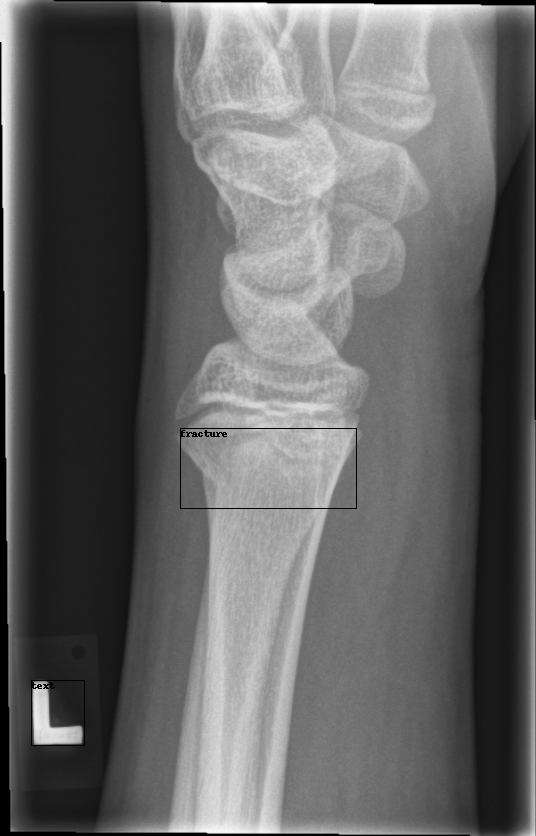

In [18]:
import numpy as np
import os
from PIL import Image, ImageDraw

# based on https://github.com/woctezuma/finetune-detr/blob/master/finetune_detr.ipynb
image_ids = train_dataset.coco.getImgIds()
# let's pick a random image
image_id = image_ids[np.random.randint(0, len(image_ids))]
print('Image n°{}'.format(image_id))
image = train_dataset.coco.loadImgs(image_id)[0]
image = Image.open(os.path.join(image['file_name']))

annotations = train_dataset.coco.imgToAnns[image_id]
draw = ImageDraw.Draw(image)

cats = train_dataset.coco.cats
id2label = {k: v['name'] for k,v in cats.items()}

for annotation in annotations:
  box = annotation['bbox']
  class_idx = annotation['category_id']
  x,y,w,h = tuple(box)
  draw.rectangle((x,y,x+w,y+h), outline='red', width=1)
  draw.text((x, y), id2label[class_idx], fill='white')

image

#### Create a train loader 

In [43]:
from torch.utils.data import DataLoader

def collate_fn(batch):
  pixel_values = [item[0] for item in batch]
  encoding = processor.pad(pixel_values, return_tensors="pt")
  labels = [item[1] for item in batch]
  batch = {}
  batch['pixel_values'] = encoding['pixel_values']
  batch['pixel_mask'] = encoding['pixel_mask']
  batch['labels'] = labels
  return batch

train_dataloader = DataLoader(train_dataset, collate_fn=collate_fn, batch_size=2, shuffle=True)

In [44]:
batch = next(iter(train_dataloader))

c:\Users\spiro\anaconda3\lib\site-packages\transformers\models\detr\image_processing_detr.py:882: FutureWarning: The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
  warnings.warn(


In [45]:
batch.keys()

dict_keys(['pixel_values', 'pixel_mask', 'labels'])

In [46]:
pixel_values, target = train_dataset[0]

In [47]:
pixel_values.shape

torch.Size([3, 1247, 800])

In [88]:
import matplotlib.pyplot as plt

plt.imshow(np.asanyarray(pixel_values.permute(1, 2, 0)))

RuntimeError: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 4 is not equal to len(dims) = 3

In [25]:
print(target)

{'size': tensor([1247,  800]), 'image_id': tensor([1]), 'class_labels': tensor([2, 1]), 'boxes': tensor([[0.1073, 0.8523, 0.0989, 0.0778],
        [0.5000, 0.5598, 0.3284, 0.0957]]), 'area': tensor([ 7669.6333, 31346.4258]), 'iscrowd': tensor([0, 0]), 'orig_size': tensor([836, 536])}


In [27]:
len(id2label)

2

In [34]:
from transformers import DetrConfig, DetrForObjectDetection

checkpoint = "facebook/detr-resnet-50"


model = DetrForObjectDetection.from_pretrained(checkpoint,num_labels=len(id2label),ignore_mismatched_sizes=True)

Some weights of DetrForObjectDetection were not initialized from the model checkpoint at facebook/detr-resnet-50 and are newly initialized because the shapes did not match:
- class_labels_classifier.weight: found shape torch.Size([92, 256]) in the checkpoint and torch.Size([3, 256]) in the model instantiated
- class_labels_classifier.bias: found shape torch.Size([92]) in the checkpoint and torch.Size([3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [37]:
model.eval()

DetrForObjectDetection(
  (model): DetrModel(
    (backbone): DetrConvModel(
      (conv_encoder): DetrConvEncoder(
        (model): FeatureListNet(
          (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
          (bn1): DetrFrozenBatchNorm2d()
          (act1): ReLU(inplace=True)
          (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
          (layer1): Sequential(
            (0): Bottleneck(
              (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (bn1): DetrFrozenBatchNorm2d()
              (act1): ReLU(inplace=True)
              (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (bn2): DetrFrozenBatchNorm2d()
              (drop_block): Identity()
              (act2): ReLU(inplace=True)
              (aa): Identity()
              (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      

In [51]:
outputs = model(pixel_values=batch['pixel_values'], pixel_mask=batch['pixel_mask'])

In [52]:
outputs.logits.shape

torch.Size([1, 100, 3])

In [54]:

def convert_to_xywh(boxes):
    xmin, ymin, xmax, ymax = boxes.unbind(1)
    return torch.stack((xmin, ymin, xmax - xmin, ymax - ymin), dim=1)

def prepare_for_coco_detection(predictions):
    coco_results = []
    for original_id, prediction in predictions.items():
        if len(prediction) == 0:
            continue

        boxes = prediction["boxes"]
        boxes = convert_to_xywh(boxes).tolist()
        scores = prediction["scores"].tolist()
        labels = prediction["labels"].tolist()

        coco_results.extend(
            [
                {
                    "image_id": original_id,
                    "category_id": labels[k],
                    "bbox": box,
                    "score": scores[k],
                }
                for k, box in enumerate(boxes)
            ]
        )
    return coco_results

In [55]:
from coco_eval import CocoEvaluator
from tqdm.notebook import tqdm

In [56]:
evaluator = CocoEvaluator(coco_gt=train_dataset.coco, iou_types=["bbox"])

In [57]:
# train on the GPU or on the CPU, if a GPU is not available
if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

No GPU available, using the CPU instead.


In [58]:
print("Running evaluation...")
for idx, batch in enumerate(tqdm(train_dataloader)):
    # get the inputs
    pixel_values = batch["pixel_values"].to(device)
    pixel_mask = batch["pixel_mask"].to(device)
    labels = [{k: v.to(device) for k, v in t.items()} for t in batch["labels"]] # these are in DETR format, resized + normalized

    # forward pass
    with torch.no_grad():
      outputs = model(pixel_values=pixel_values, pixel_mask=pixel_mask)

    # turn into a list of dictionaries (one item for each example in the batch)
    orig_target_sizes = torch.stack([target["orig_size"] for target in labels], dim=0)
    results = processor.post_process_object_detection(outputs, target_sizes=orig_target_sizes)

    # provide to metric
    # metric expects a list of dictionaries, each item 
    # containing image_id, category_id, bbox and score keys 
    predictions = {target['image_id'].item(): output for target, output in zip(labels, results)}
    predictions = prepare_for_coco_detection(predictions)
    evaluator.update(predictions)

evaluator.synchronize_between_processes()
evaluator.accumulate()
evaluator.summarize()

Running evaluation...


  0%|          | 0/1 [00:00<?, ?it/s]

KeyError: 'annotations'

#### Visualization

In [62]:
#We can use the image_id in target to know which image it is
pixel_values, target = train_dataset[0]

In [63]:
pixel_values = pixel_values.unsqueeze(0).to(device)
print(pixel_values.shape)

torch.Size([1, 3, 1247, 800])


In [64]:
with torch.no_grad():
  # forward pass to get class logits and bounding boxes
  outputs = model(pixel_values=pixel_values, pixel_mask=None)
print("Outputs:", outputs.keys())

Outputs: odict_keys(['logits', 'pred_boxes', 'last_hidden_state', 'encoder_last_hidden_state'])


In [82]:
# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

def plot_results(pil_img, scores, labels, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(np.asarray(pil_img),cmap='gray')
    ax = plt.gca()
    colors = COLORS * 100
    for score, label, (xmin, ymin, xmax, ymax),c  in zip(scores.tolist(), labels.tolist(), boxes.tolist(), colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        text = f'{model.config.id2label[label]}: {score:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

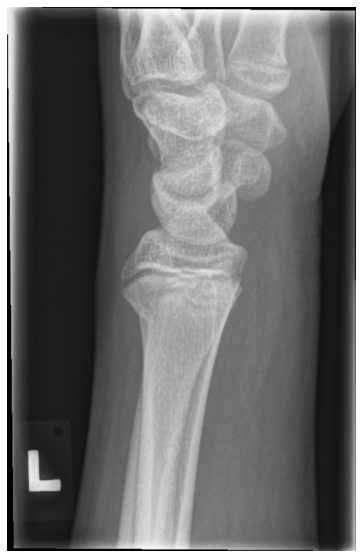

In [84]:
# load image based on ID
image_id = target['image_id'].item()
image = train_dataset.coco.loadImgs(image_id)[0]
image = Image.open(os.path.join(image['file_name']))


# postprocess model outputs
width, height = image.size
postprocessed_outputs = processor.post_process_object_detection(outputs,
                                                                target_sizes=[(height, width)],
                                                                threshold=0.9)
results = postprocessed_outputs[0]
plot_results(image, results['scores'], results['labels'], results['boxes'])

#### If i want to load one pretrained model of mine use this 

In [ ]:
from transformers import DetrImageProcessor, DetrForObjectDetection
import torch

model = DetrForObjectDetection.from_pretrained("my_model")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
processor = DetrImageProcessor.from_pretrained("my_model")